In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import phate

In [3]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [4]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = e * t**2
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df

df = make_branch_cond(ne=2, repeats=20)


In [5]:
df

,samples,e1,d1,d2
0,0,-1.0,-0.034889,0.054968
1,0,-1.0,0.151002,0.029287
2,0,-1.0,0.163355,-0.059603
3,0,-1.0,0.164923,-0.072056
4,1,-1.0,0.288280,-0.067361
...,...,...,...,...
795,3,1.0,0.932206,0.523483
796,4,1.0,0.930819,0.788406
797,4,1.0,1.034536,0.757093
798,4,1.0,0.839130,0.880604


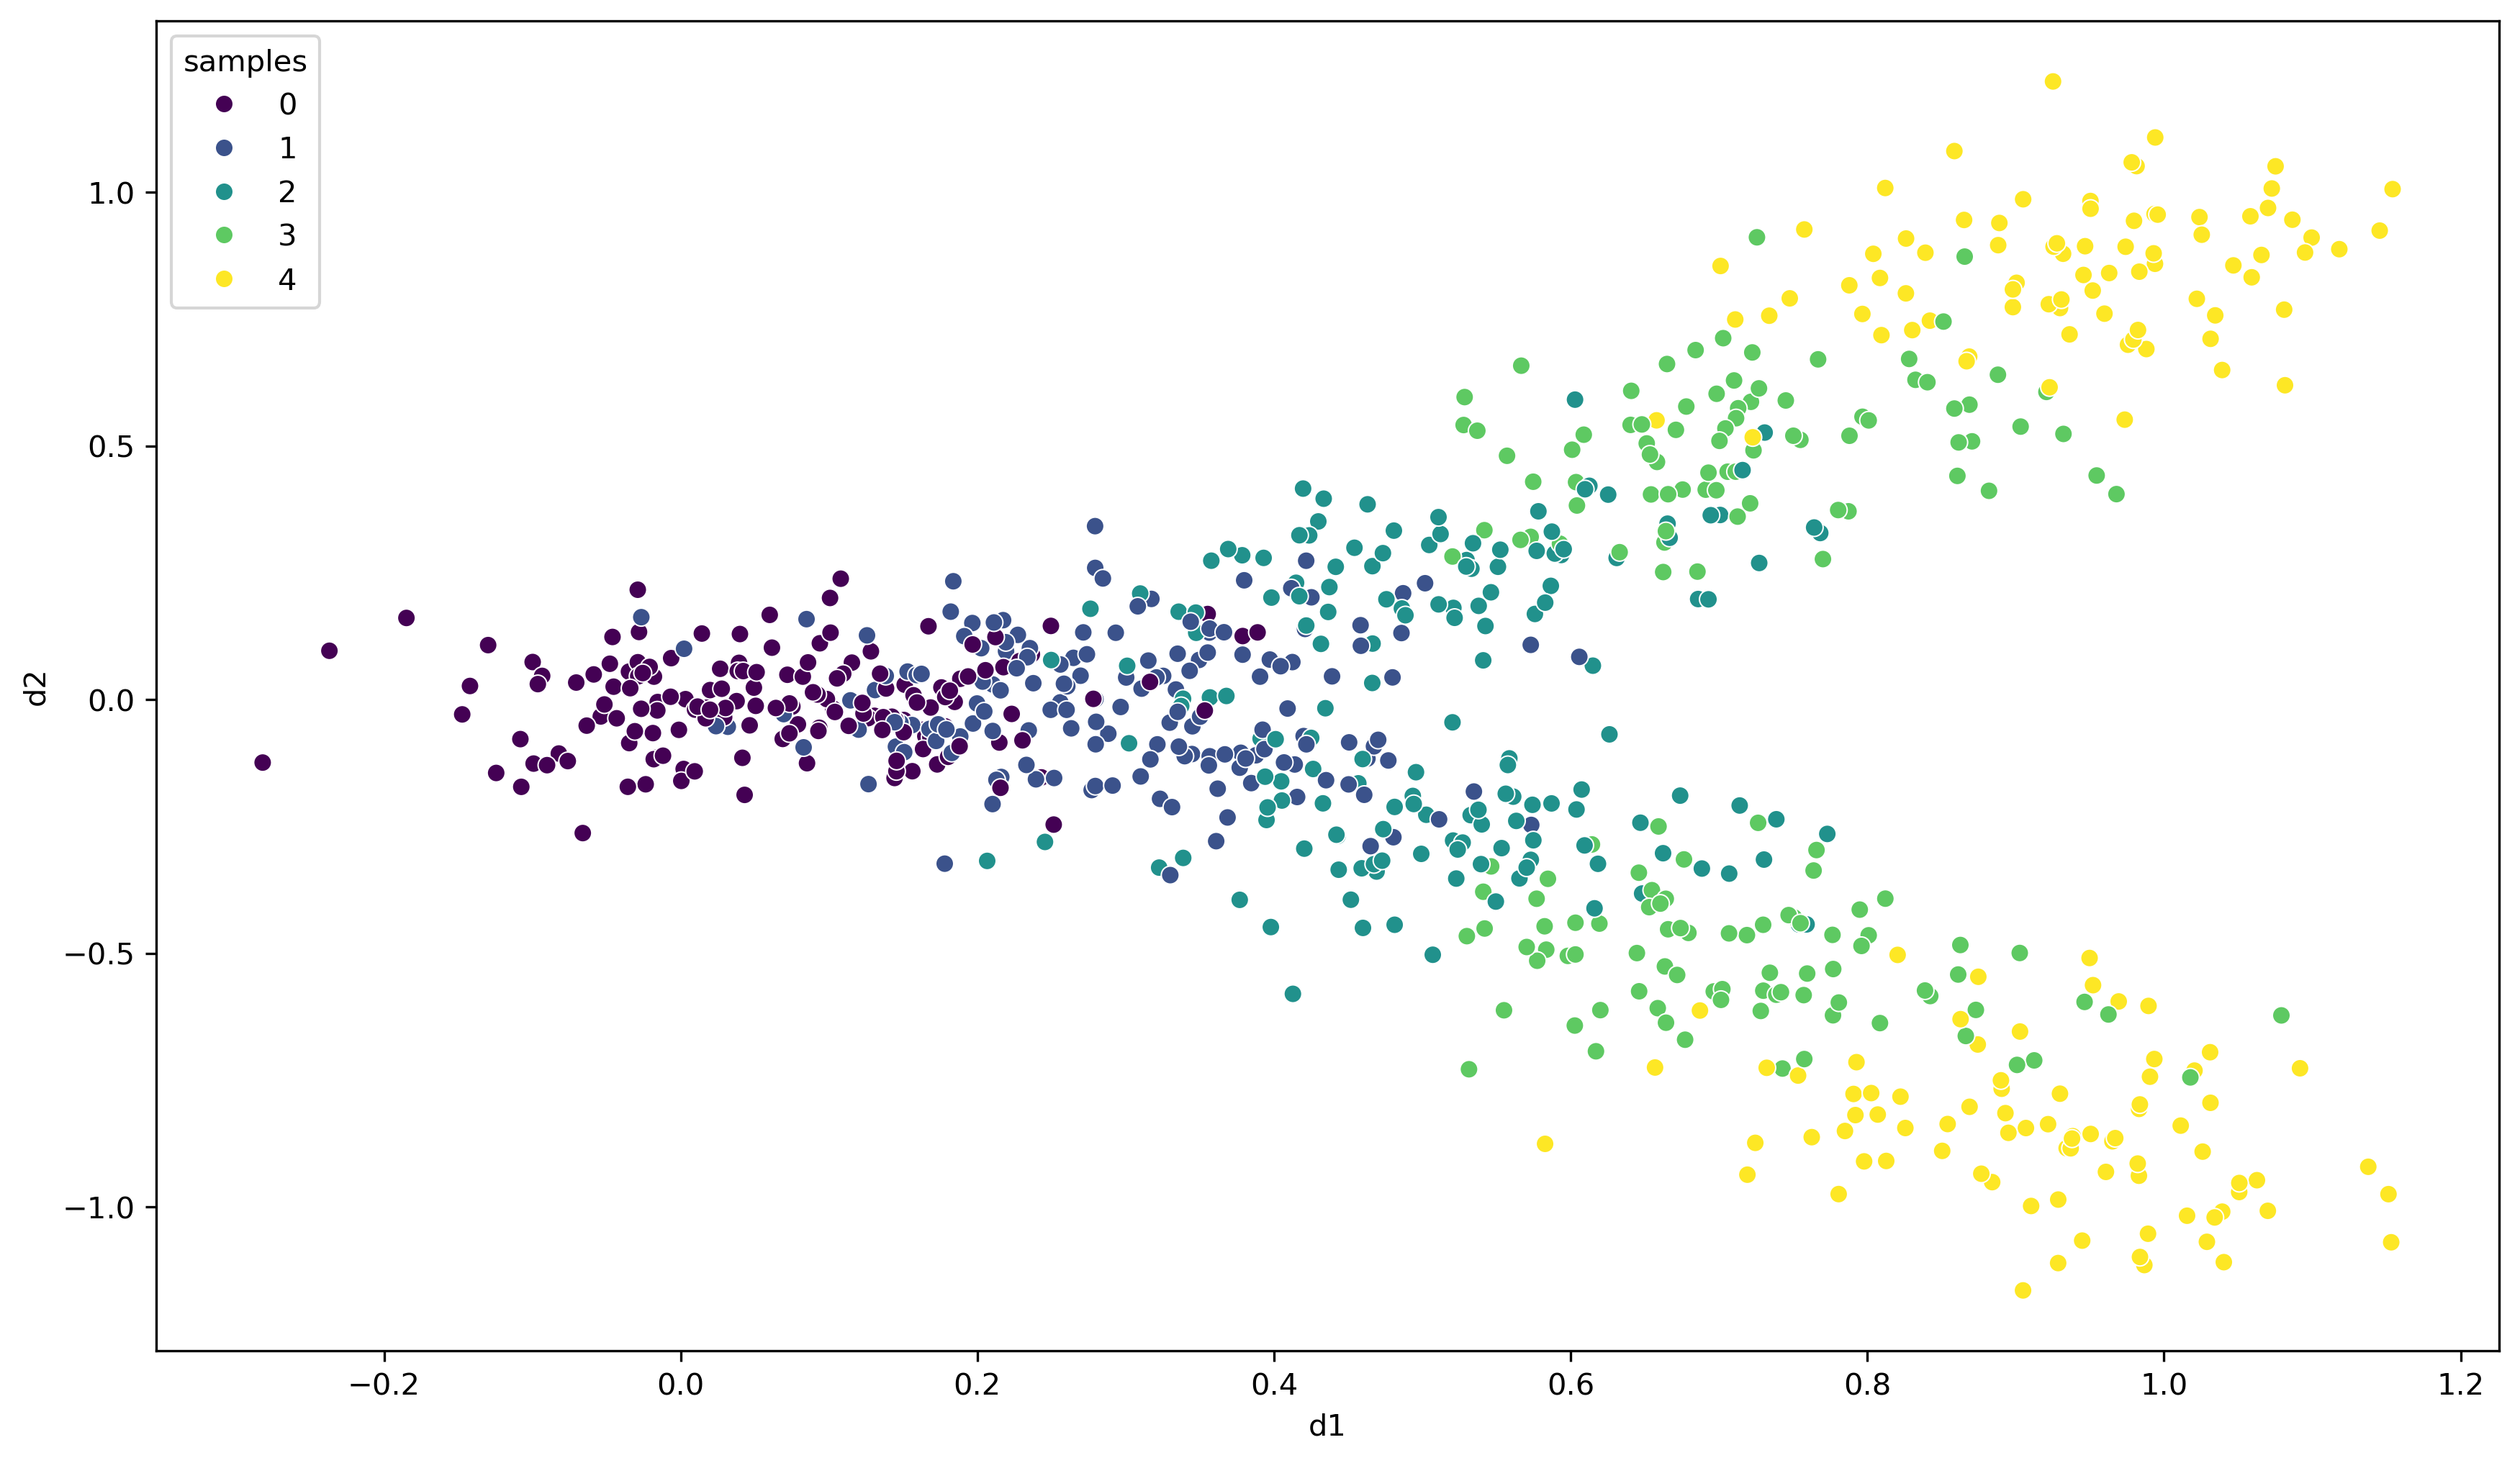

In [6]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

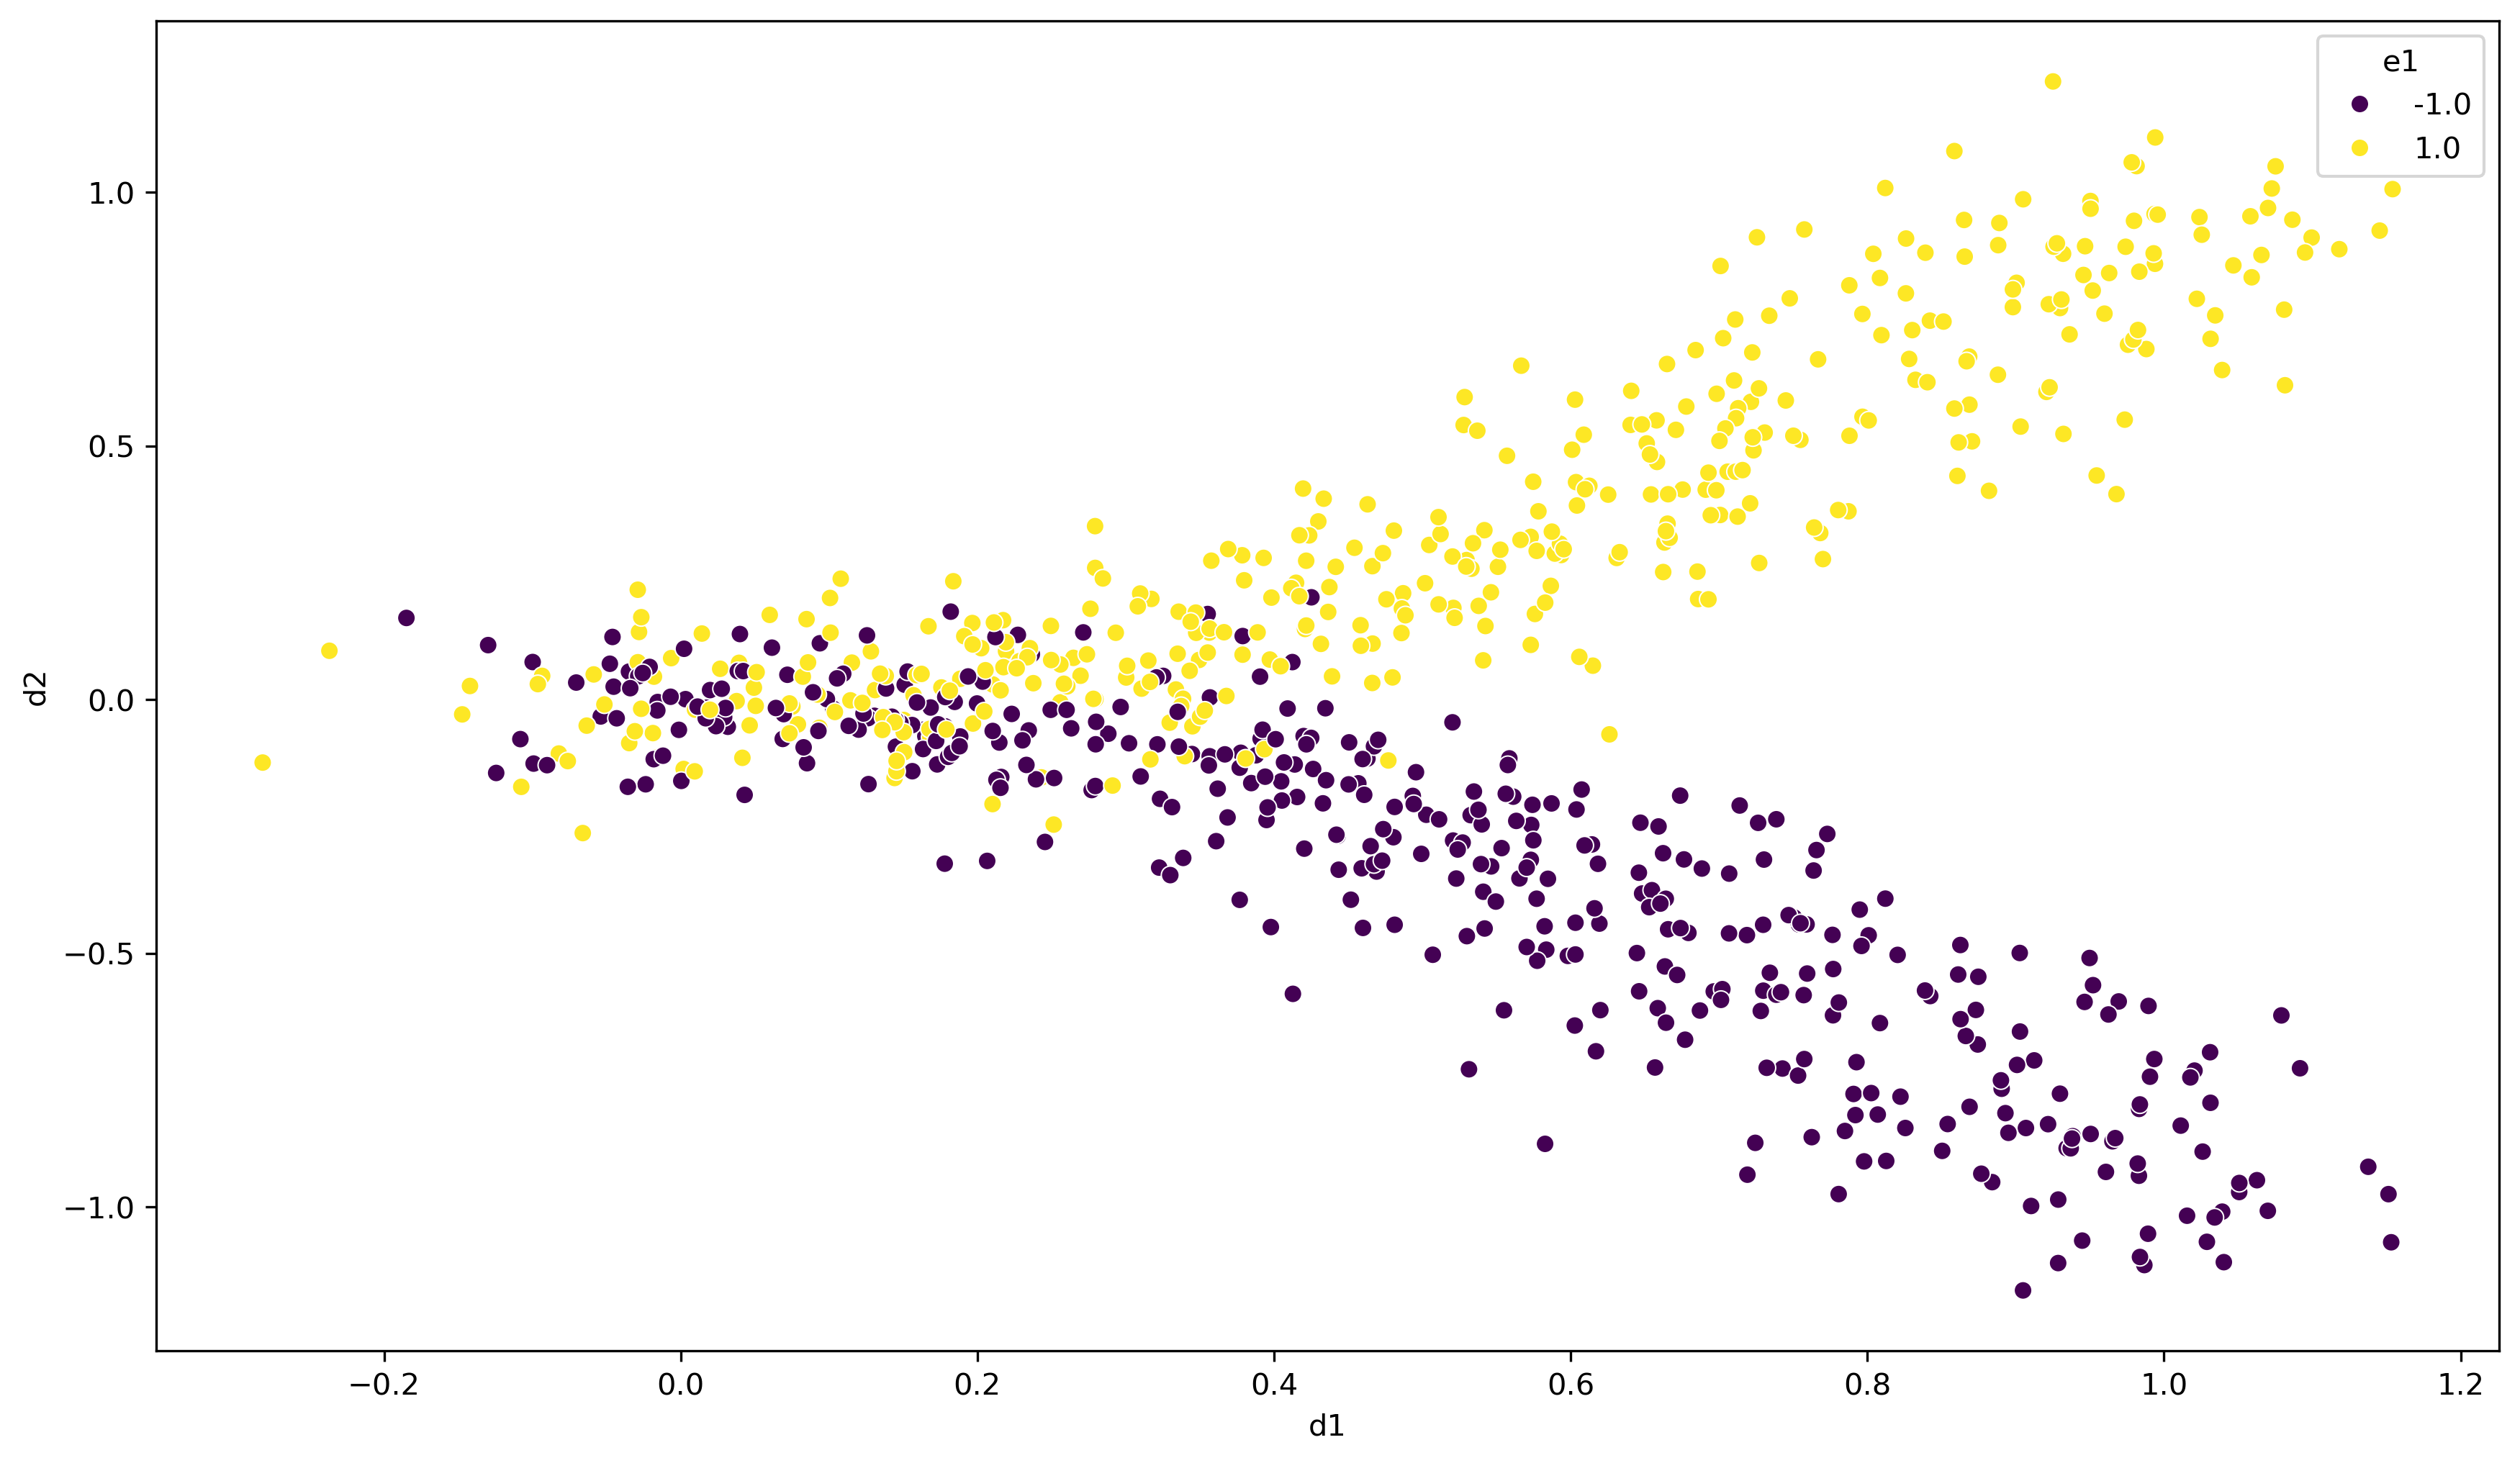

In [7]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');

In [8]:
df_copy = df.copy()
df = df.drop(columns=['e1'])

In [9]:
means = df[['d1', 'd2']].mean(axis=0)
stds = df[['d1', 'd2']].std(axis=0)
df[['d1', 'd2']] = (df[['d1', 'd2']] - means) / stds

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [10]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [11]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [12]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 3
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [13]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [14]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
# lambda_density = 35
lambda_density = 0

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim

# model = make_model(
#     model_features, layers, which='sde', method='euler',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda
# )

# model = make_model(
#     model_features, layers, which='sde', method='reversible_heun', sde_type='stratonovich', adjoint_method='adjoint_reversible_heun',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )


model1 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)
model2 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)
model3 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)
model4 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)

In [15]:
# Basically "batch size"
# sample_size=(60, )
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion1 = config_criterion(criterion_name, covariance_lambda=0.0, detach_dist_for_plan=False, detach_mass=False)
# criterion2 = config_criterion(criterion_name, covariance_lambda=0.0, detach_dist_for_plan=True, detach_mass=False)
# criterion3 = config_criterion(criterion_name, covariance_lambda=0.0, detach_dist_for_plan=False, detach_mass=True)
# criterion4 = config_criterion(criterion_name, covariance_lambda=0.0, detach_dist_for_plan=True, detach_mass=True)
criterion2 = criterion1
criterion3 = criterion1
criterion4 = criterion1

optimizer1 = torch.optim.AdamW(model1.parameters())
optimizer2 = torch.optim.AdamW(model2.parameters())
optimizer3 = torch.optim.AdamW(model3.parameters())
optimizer4 = torch.optim.AdamW(model4.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [16]:
opts = {
    'phate_dims': 2,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [17]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [18]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model1, df=df, groups=groups, optimizer=optimizer1, 
    criterion=criterion1, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=.01,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [19]:
start_time = time.time()

local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model2, df=df, groups=groups, optimizer=optimizer2, 
    criterion=criterion2, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=.1,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [20]:
start_time = time.time()

local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model3, df=df, groups=groups, optimizer=optimizer3, 
    criterion=criterion3, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=1,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [21]:
start_time = time.time()

local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model4, df=df, groups=groups, optimizer=optimizer4, 
    criterion=criterion4, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=10,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

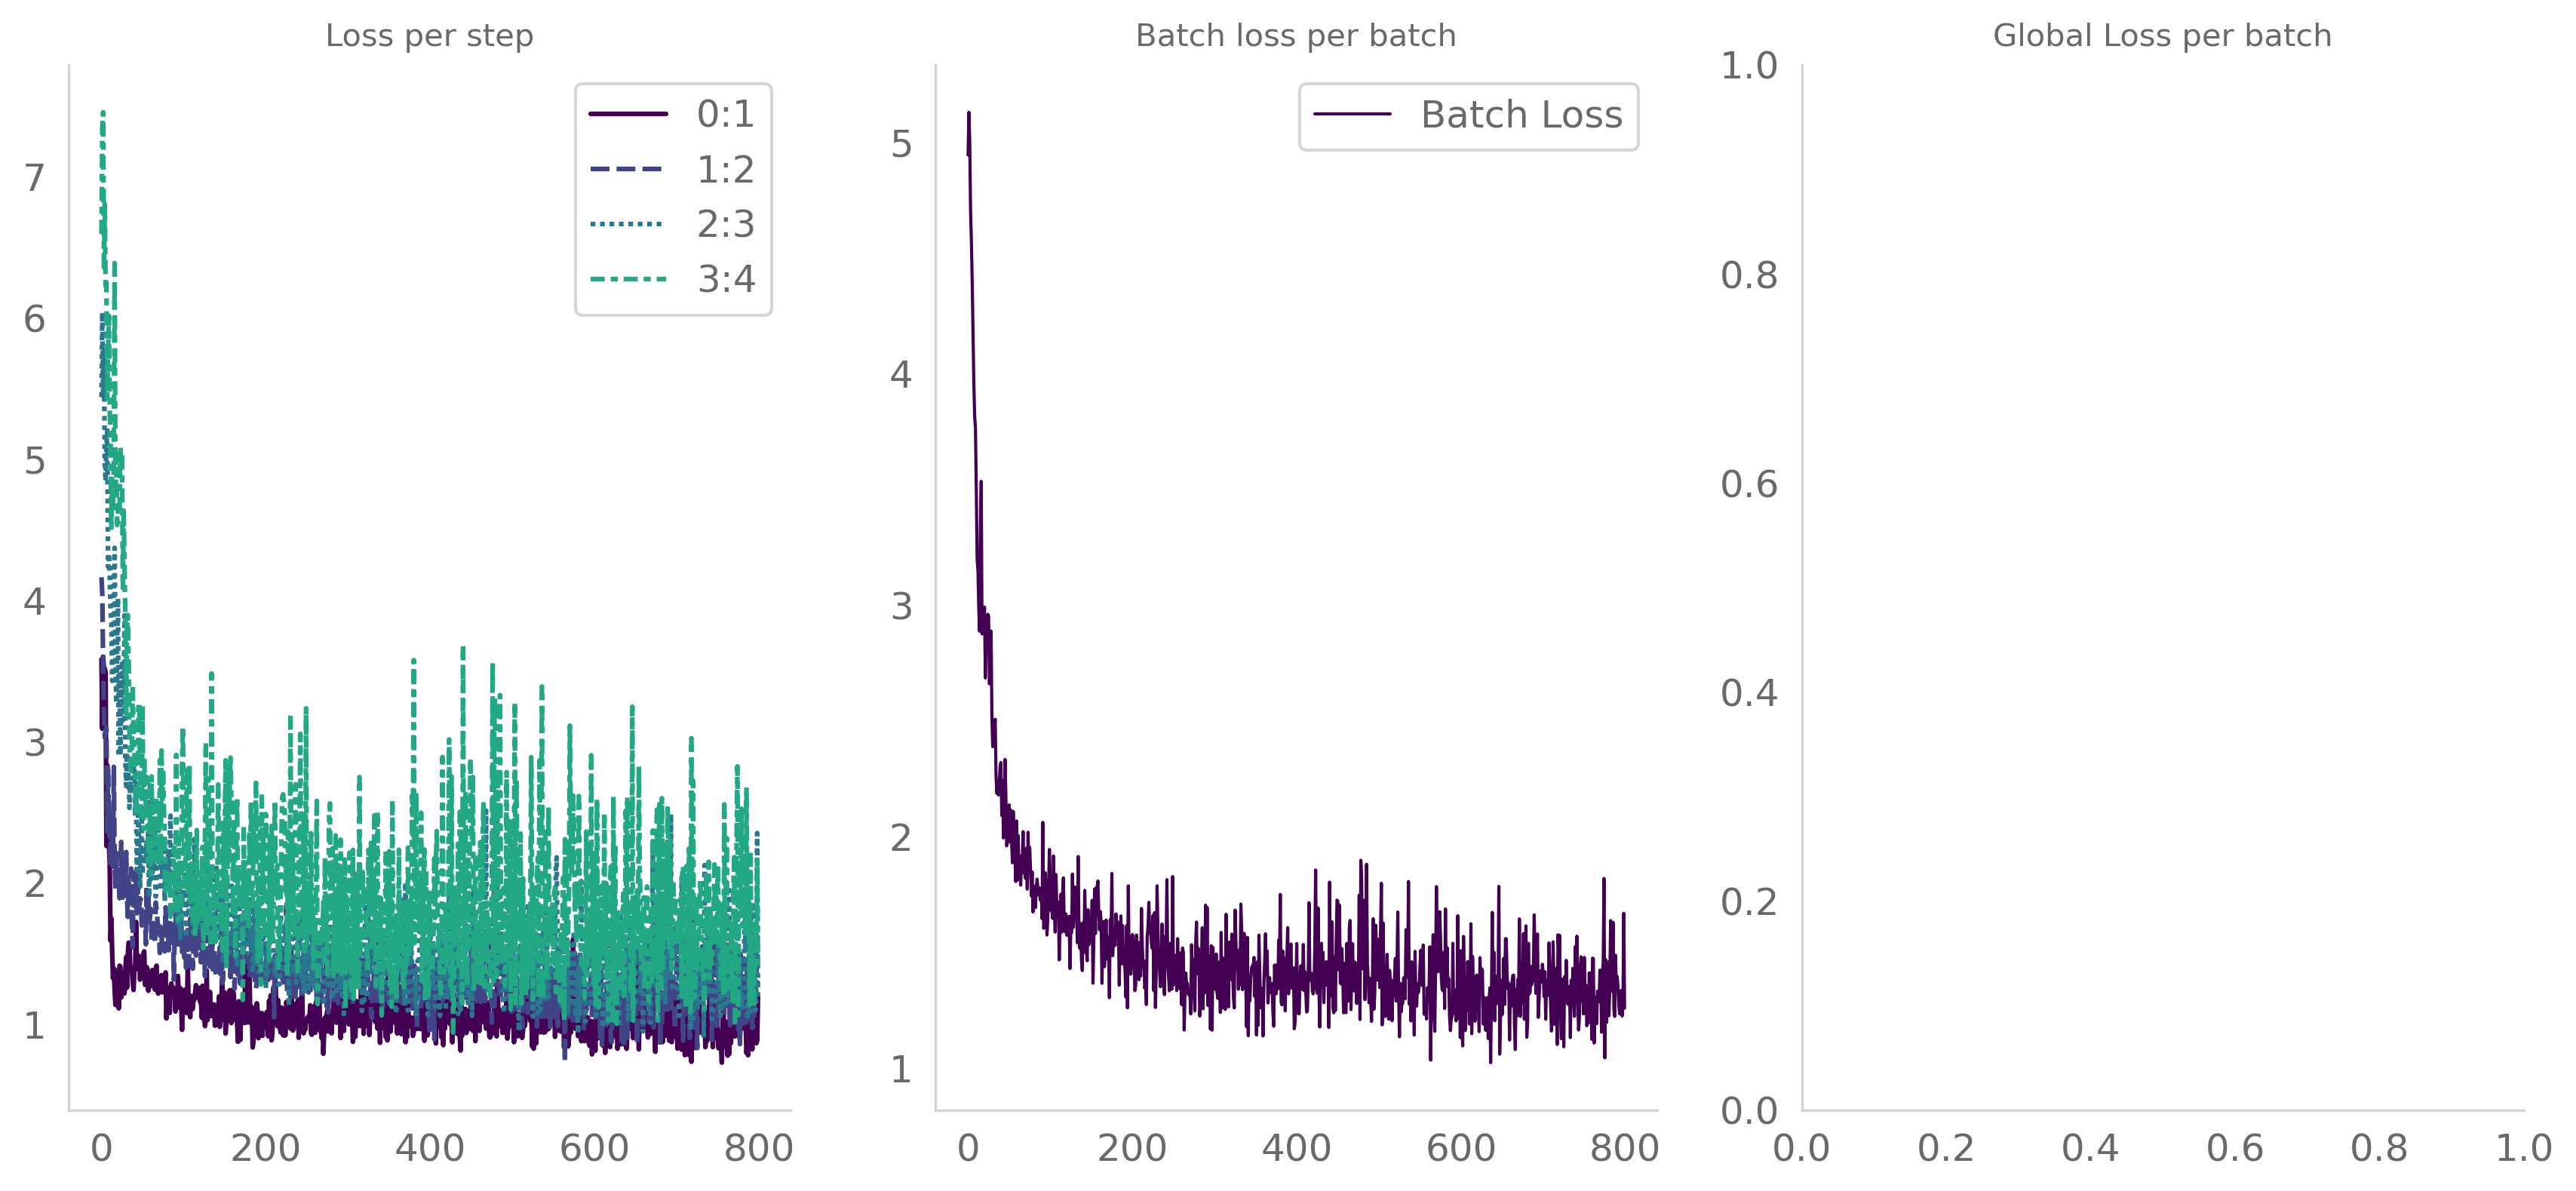

In [22]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

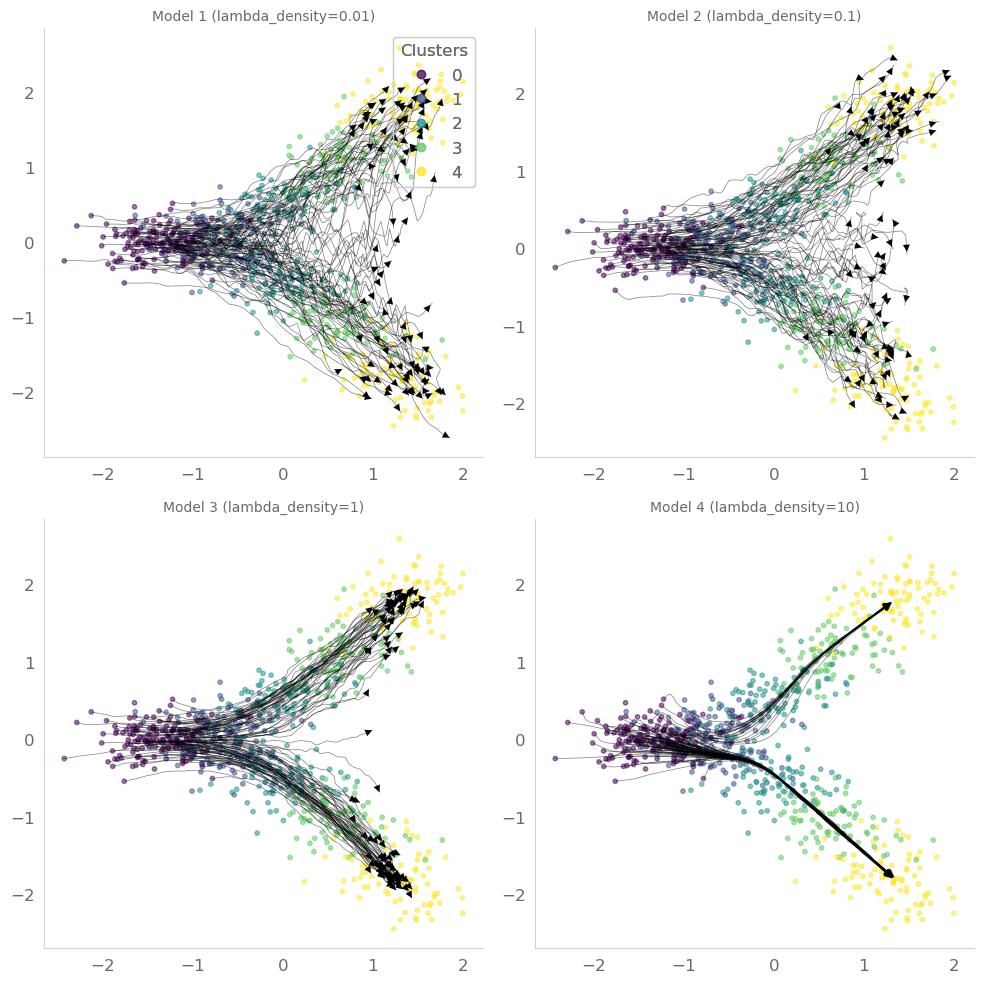

In [23]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
models = [model1, model2, model3, model4]
titles = ['Model 1 (lambda_density=0.01)', 'Model 2 (lambda_density=0.1)', 'Model 3 (lambda_density=1)', 'Model 4 (lambda_density=10)']

for idx, (ax, model, title) in enumerate(zip(axes.flat, models, titles)):
    with torch.no_grad():
        x_traj = model(data_t0, sample_time, return_whole_sequence=True)
    
    scatter = ax.scatter(df['d1'], df['d2'],
                    c=df['samples'], cmap='viridis', s=10, alpha=.5)
    
    # Add legend only to first subplot
    if idx == 0:
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Clusters")
        ax.add_artist(legend1)
    
    for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
        ax.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
        ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                     arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))
    ax.set_title(title)

plt.tight_layout()

In [24]:
t0 = 0
t1 = 4
data_t0 = sample(
    df, t0, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, t1, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time1 = torch.tensor([t0,t1], dtype=data_t0.dtype, device=data_t0.device)
with torch.no_grad():
    x_traj1 = model(data_t0, sample_time1, return_whole_sequence=False)
    x_traj2 = model2(data_t0, sample_time1, return_whole_sequence=False)

loss1_cov = criterion(x_traj1, data_t1)
loss2_cov = criterion(x_traj2, data_t1)
loss1_ot = criterion2(x_traj1, data_t1)
loss2_ot = criterion2(x_traj2, data_t1)

from tabulate import tabulate
data = [
    ["Model 1 (trained with covariance)", loss1_cov.item(), loss1_ot.item()],
    ["Model 2 (trained with OT)", loss2_cov.item(), loss2_ot.item()]
]
headers = ["Model", "Covariance Loss", "OT Loss"]
print(tabulate(data, headers=headers, tablefmt="grid"))

plt.figure(figsize=(5, 5))
plt.scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
plt.scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model')
plt.scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
plt.legend()


NameError: name 'criterion' is not defined

+-----------------------------------+-------------------+-----------+------------+
| Model                             |   Covariance Loss |   OT Loss |   EMD Loss |
+===================================+===================+===========+============+
| Model 1 (trained with covariance) |           52.0564 | 1.00245   |  1.00245   |
+-----------------------------------+-------------------+-----------+------------+
| Model 2 (trained with OT)         |           17.9211 | 0.0787557 |  0.0787557 |
+-----------------------------------+-------------------+-----------+------------+
| Model 3 (trained with EMD)        |           64.0935 | 2.19557   |  2.19557   |
+-----------------------------------+-------------------+-----------+------------+


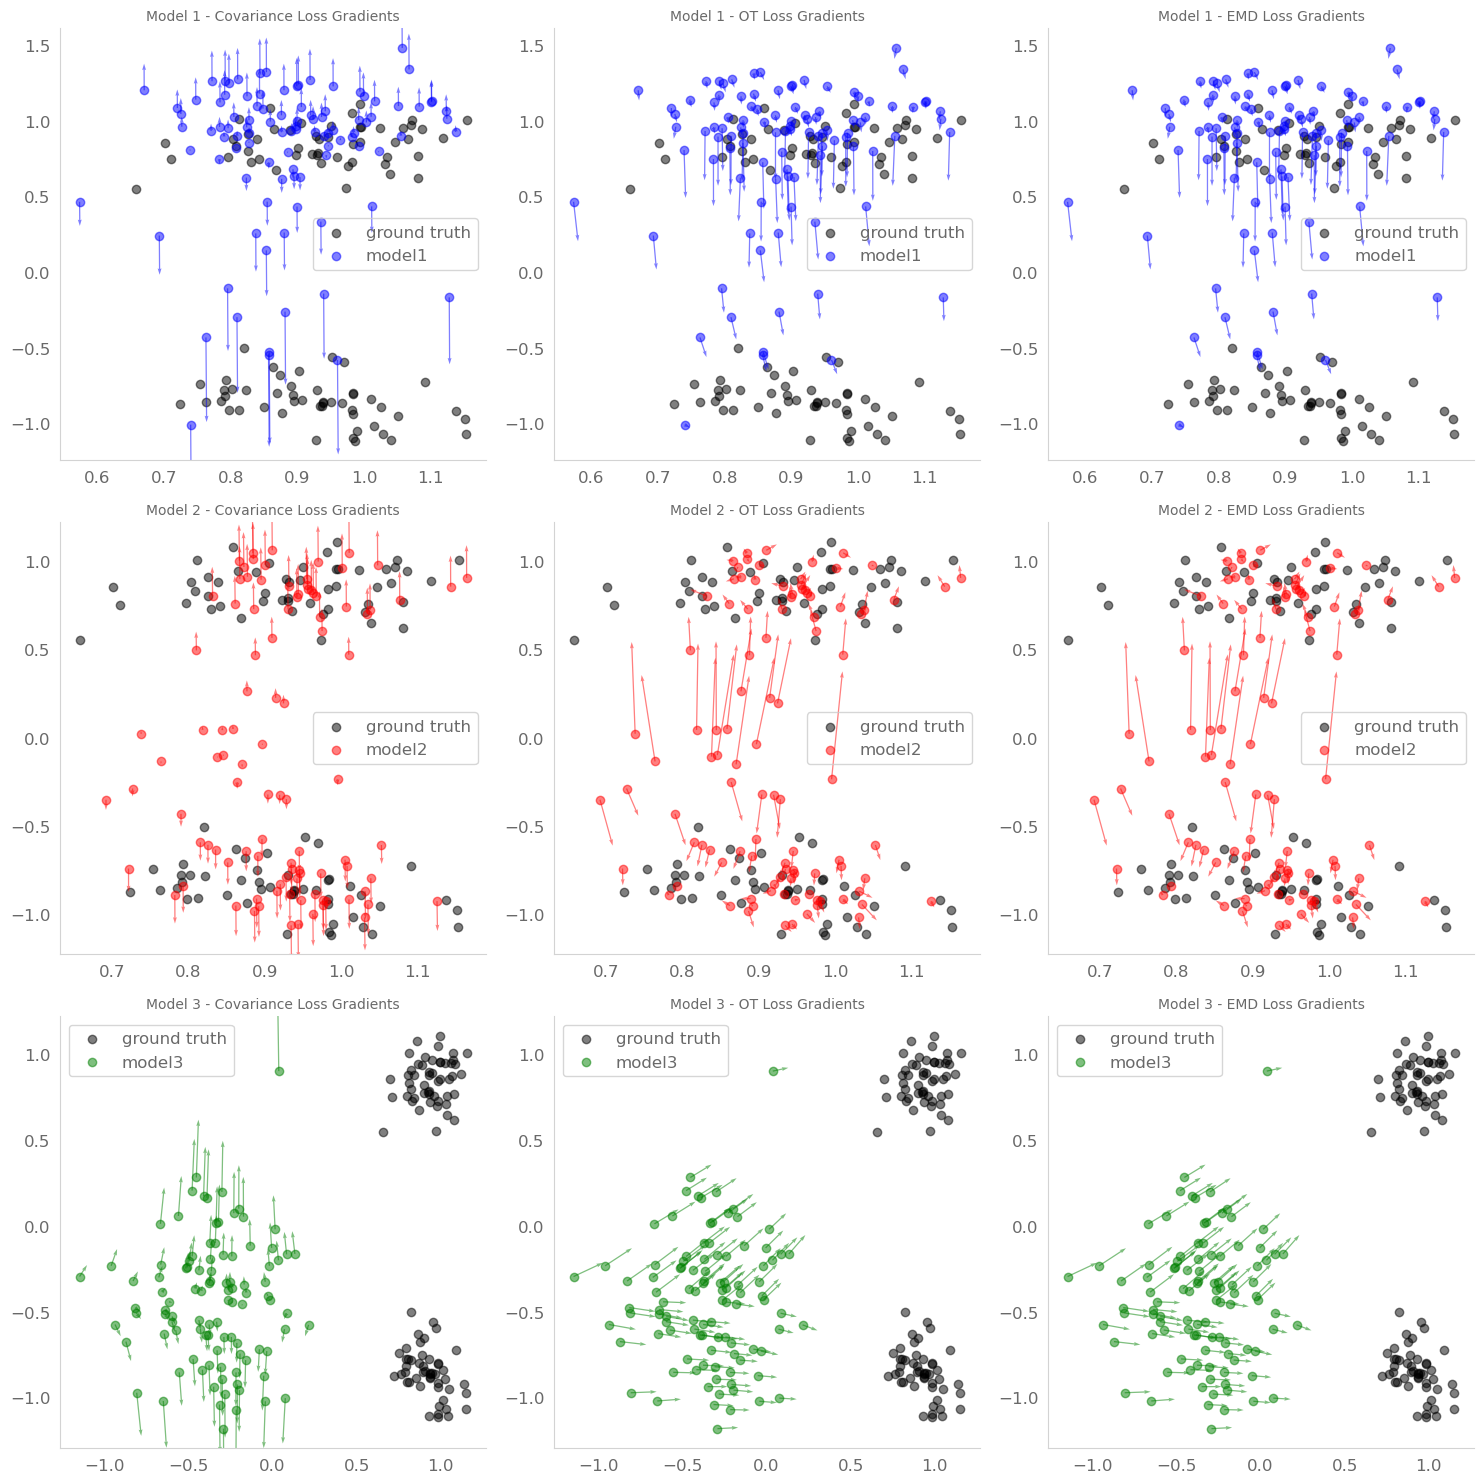

In [96]:
t0 = 0
t1 = 4
data_t0 = sample(
    df, t0, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, t1, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time1 = torch.tensor([t0,t1], dtype=data_t0.dtype, device=data_t0.device)
with torch.no_grad():
    x_traj1 = model(data_t0, sample_time1, return_whole_sequence=False)
    x_traj2 = model2(data_t0, sample_time1, return_whole_sequence=False)
    x_traj3 = model3(data_t0, sample_time1, return_whole_sequence=False)

# Create tensors that require gradients
x_traj1_grad = x_traj1.detach().clone().requires_grad_(True) 
x_traj2_grad = x_traj2.detach().clone().requires_grad_(True)
x_traj3_grad = x_traj3.detach().clone().requires_grad_(True)

# Compute losses and gradients for covariance criterion
loss1_cov = criterion(x_traj1_grad, data_t1)
loss1_cov.backward()
grad1_cov = x_traj1_grad.grad.detach()
x_traj1_grad.grad = None

loss2_cov = criterion(x_traj2_grad, data_t1)
loss2_cov.backward()
grad2_cov = x_traj2_grad.grad.detach()
x_traj2_grad.grad = None

loss3_cov = criterion(x_traj3_grad, data_t1)
loss3_cov.backward()
grad3_cov = x_traj3_grad.grad.detach()
x_traj3_grad.grad = None

# Compute losses and gradients for OT criterion
loss1_ot = criterion2(x_traj1_grad, data_t1)
loss1_ot.backward()
grad1_ot = x_traj1_grad.grad.detach()
x_traj1_grad.grad = None

loss2_ot = criterion2(x_traj2_grad, data_t1)
loss2_ot.backward()
grad2_ot = x_traj2_grad.grad.detach()
x_traj2_grad.grad = None

loss3_ot = criterion2(x_traj3_grad, data_t1)
loss3_ot.backward()
grad3_ot = x_traj3_grad.grad.detach()
x_traj3_grad.grad = None

# Compute losses for EMD criterion
loss1_emd = criterion3(x_traj1_grad, data_t1)
loss1_emd.backward()
grad1_emd = x_traj1_grad.grad.detach()
x_traj1_grad.grad = None

loss2_emd = criterion3(x_traj2_grad, data_t1)
loss2_emd.backward()
grad2_emd = x_traj2_grad.grad.detach()
x_traj2_grad.grad = None

loss3_emd = criterion3(x_traj3_grad, data_t1)
loss3_emd.backward()
grad3_emd = x_traj3_grad.grad.detach()

# Print loss table
data = [
    ["Model 1 (trained with covariance)", loss1_cov.item(), loss1_ot.item(), loss1_emd.item()],
    ["Model 2 (trained with OT)", loss2_cov.item(), loss2_ot.item(), loss2_emd.item()],
    ["Model 3 (trained with EMD)", loss3_cov.item(), loss3_ot.item(), loss3_emd.item()]
]
headers = ["Model", "Covariance Loss", "OT Loss", "EMD Loss"]
print(tabulate(data, headers=headers, tablefmt="grid"))

# Plot results in 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot for model1 (row 0)
axes[0,0].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[0,0].scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model1')
axes[0,0].quiver(x_traj1[:,0], x_traj1[:,1], -grad1_cov[:,0], -grad1_cov[:,1], 
           color='Blue', alpha=0.5, width=0.003)
axes[0,0].set_title('Model 1 - Covariance Loss Gradients')
axes[0,0].legend()

axes[0,1].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[0,1].scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model1')
axes[0,1].quiver(x_traj1[:,0], x_traj1[:,1], -grad1_ot[:,0], -grad1_ot[:,1], 
           color='Blue', alpha=0.5, width=0.003)
axes[0,1].set_title('Model 1 - OT Loss Gradients')
axes[0,1].legend()

axes[0,2].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[0,2].scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model1')
axes[0,2].quiver(x_traj1[:,0], x_traj1[:,1], -grad1_emd[:,0], -grad1_emd[:,1], 
           color='Blue', alpha=0.5, width=0.003)
axes[0,2].set_title('Model 1 - EMD Loss Gradients')
axes[0,2].legend()

# Plot for model2 (row 1)
axes[1,0].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[1,0].scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
axes[1,0].quiver(x_traj2[:,0], x_traj2[:,1], -grad2_cov[:,0], -grad2_cov[:,1], 
           color='Red', alpha=0.5, width=0.003)
axes[1,0].set_title('Model 2 - Covariance Loss Gradients')
axes[1,0].legend()

axes[1,1].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[1,1].scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
axes[1,1].quiver(x_traj2[:,0], x_traj2[:,1], -grad2_ot[:,0], -grad2_ot[:,1], 
           color='Red', alpha=0.5, width=0.003)
axes[1,1].set_title('Model 2 - OT Loss Gradients')
axes[1,1].legend()

axes[1,2].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[1,2].scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
axes[1,2].quiver(x_traj2[:,0], x_traj2[:,1], -grad2_emd[:,0], -grad2_emd[:,1], 
           color='Red', alpha=0.5, width=0.003)
axes[1,2].set_title('Model 2 - EMD Loss Gradients')
axes[1,2].legend()

# Plot for model3 (row 2)
axes[2,0].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[2,0].scatter(x_traj3[:,0], x_traj3[:,1], alpha=.5, color='Green', label='model3')
axes[2,0].quiver(x_traj3[:,0], x_traj3[:,1], -grad3_cov[:,0], -grad3_cov[:,1], 
           color='Green', alpha=0.5, width=0.003)
axes[2,0].set_title('Model 3 - Covariance Loss Gradients')
axes[2,0].legend()

axes[2,1].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[2,1].scatter(x_traj3[:,0], x_traj3[:,1], alpha=.5, color='Green', label='model3')
axes[2,1].quiver(x_traj3[:,0], x_traj3[:,1], -grad3_ot[:,0], -grad3_ot[:,1], 
           color='Green', alpha=0.5, width=0.003)
axes[2,1].set_title('Model 3 - OT Loss Gradients')
axes[2,1].legend()

axes[2,2].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[2,2].scatter(x_traj3[:,0], x_traj3[:,1], alpha=.5, color='Green', label='model3')
axes[2,2].quiver(x_traj3[:,0], x_traj3[:,1], -grad3_emd[:,0], -grad3_emd[:,1], 
           color='Green', alpha=0.5, width=0.003)
axes[2,2].set_title('Model 3 - EMD Loss Gradients')
axes[2,2].legend()

plt.tight_layout()


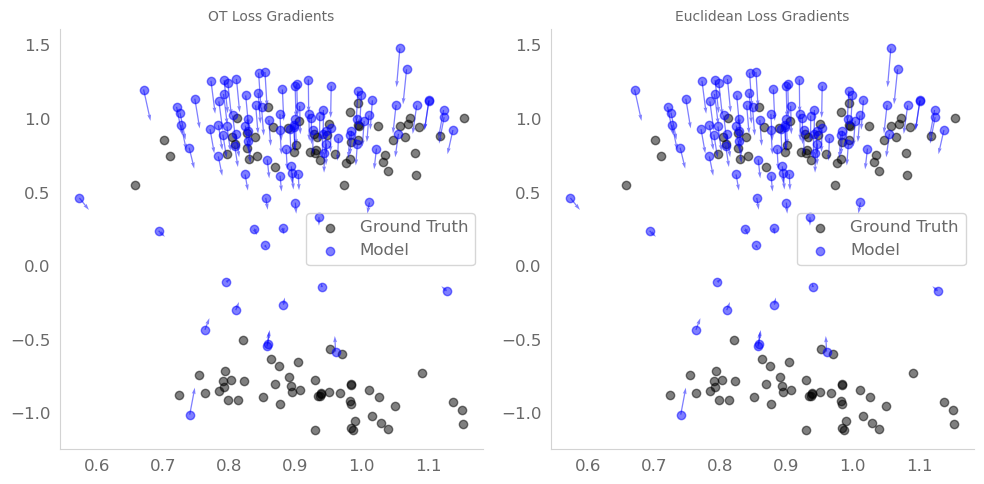

In [97]:
# Calculate OT distance loss and gradients
loss_ot = ot.dist(x_traj1_grad.requires_grad_(True), data_t1).sum()
loss_ot.backward()
grad_ot = x_traj1_grad.grad.clone()
x_traj1_grad.grad = None

# Calculate Euclidean distance loss and gradients 
loss_euc = (torch.cdist(x_traj1_grad, data_t1) ** 2).sum()
loss_euc.backward()
grad_euc = x_traj1_grad.grad.clone()

# Plot comparison
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(data_t1[:,0], data_t1[:,1], alpha=0.5, color='black', label='Ground Truth')
plt.scatter(x_traj1_grad[:,0].detach(), x_traj1_grad[:,1].detach(), alpha=0.5, color='blue', label='Model')
plt.quiver(x_traj1_grad[:,0].detach(), x_traj1_grad[:,1].detach(), 
          -grad_ot[:,0], -grad_ot[:,1],
          color='blue', alpha=0.5, width=0.003)
plt.title('OT Loss Gradients')
plt.legend()

plt.subplot(122)
plt.scatter(data_t1[:,0], data_t1[:,1], alpha=0.5, color='black', label='Ground Truth')
plt.scatter(x_traj1_grad[:,0].detach(), x_traj1_grad[:,1].detach(), alpha=0.5, color='blue', label='Model')
plt.quiver(x_traj1_grad[:,0].detach(), x_traj1_grad[:,1].detach(),
          -grad_euc[:,0], -grad_euc[:,1],
          color='blue', alpha=0.5, width=0.003)
plt.title('Euclidean Loss Gradients')
plt.legend()

plt.tight_layout()

In [98]:
criterion3(x_traj1, data_t1)

tensor(1.0024)

+-----------------------------------+-------------------+------------+------------+
| Model                             |   Covariance Loss |    OT Loss |   EMD Loss |
+===================================+===================+============+============+
| Model 1 (trained with covariance) |          0.429289 | 0.0193942  | 0.0193942  |
+-----------------------------------+-------------------+------------+------------+
| Model 2 (trained with OT)         |          0.259513 | 0.00286357 | 0.00286357 |
+-----------------------------------+-------------------+------------+------------+
| Model 3 (trained with EMD)        |          2.61889  | 0.160773   | 0.160773   |
+-----------------------------------+-------------------+------------+------------+


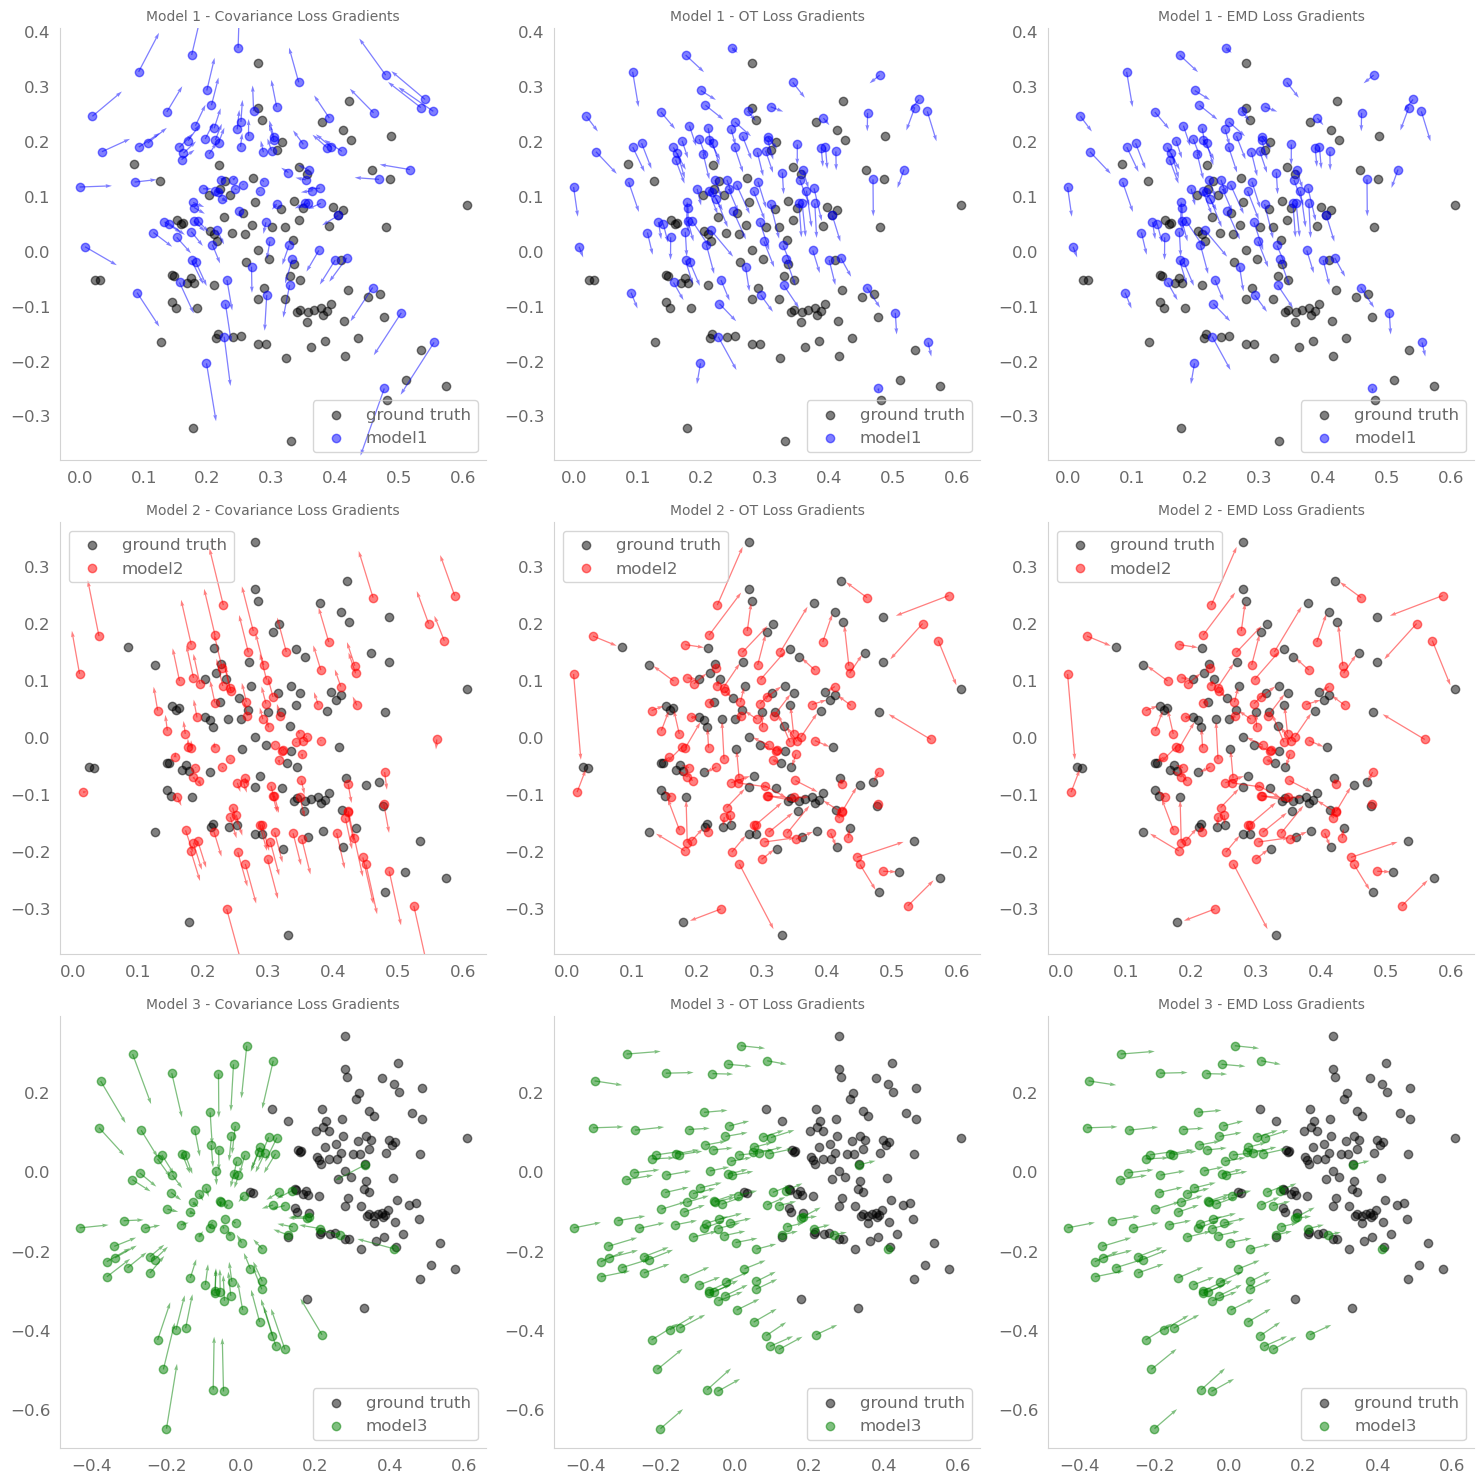

In [99]:
t0 = 0
t1 = 1
data_t0 = sample(
    df, t0, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, t1, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time1 = torch.tensor([t0,t1], dtype=data_t0.dtype, device=data_t0.device)
with torch.no_grad():
    x_traj1 = model(data_t0, sample_time1, return_whole_sequence=False)
    x_traj2 = model2(data_t0, sample_time1, return_whole_sequence=False)
    x_traj3 = model3(data_t0, sample_time1, return_whole_sequence=False)

# Create tensors that require gradients
x_traj1_grad = x_traj1.detach().clone().requires_grad_(True) 
x_traj2_grad = x_traj2.detach().clone().requires_grad_(True)
x_traj3_grad = x_traj3.detach().clone().requires_grad_(True)

# Compute losses and gradients for covariance criterion
loss1_cov = criterion(x_traj1_grad, data_t1)
loss1_cov.backward()
grad1_cov = x_traj1_grad.grad.detach()
x_traj1_grad.grad = None

loss2_cov = criterion(x_traj2_grad, data_t1)
loss2_cov.backward()
grad2_cov = x_traj2_grad.grad.detach()
x_traj2_grad.grad = None

loss3_cov = criterion(x_traj3_grad, data_t1)
loss3_cov.backward()
grad3_cov = x_traj3_grad.grad.detach()
x_traj3_grad.grad = None

# Compute losses and gradients for OT criterion
loss1_ot = criterion2(x_traj1_grad, data_t1)
loss1_ot.backward()
grad1_ot = x_traj1_grad.grad.detach()
x_traj1_grad.grad = None

loss2_ot = criterion2(x_traj2_grad, data_t1)
loss2_ot.backward()
grad2_ot = x_traj2_grad.grad.detach()
x_traj2_grad.grad = None

loss3_ot = criterion2(x_traj3_grad, data_t1)
loss3_ot.backward()
grad3_ot = x_traj3_grad.grad.detach()
x_traj3_grad.grad = None

# Compute losses for EMD criterion
loss1_emd = criterion3(x_traj1_grad, data_t1)
loss1_emd.backward()
grad1_emd = x_traj1_grad.grad.detach()
x_traj1_grad.grad = None

loss2_emd = criterion3(x_traj2_grad, data_t1)
loss2_emd.backward()
grad2_emd = x_traj2_grad.grad.detach()
x_traj2_grad.grad = None

loss3_emd = criterion3(x_traj3_grad, data_t1)
loss3_emd.backward()
grad3_emd = x_traj3_grad.grad.detach()

# Print loss table
data = [
    ["Model 1 (trained with covariance)", loss1_cov.item(), loss1_ot.item(), loss1_emd.item()],
    ["Model 2 (trained with OT)", loss2_cov.item(), loss2_ot.item(), loss2_emd.item()],
    ["Model 3 (trained with EMD)", loss3_cov.item(), loss3_ot.item(), loss3_emd.item()]
]
headers = ["Model", "Covariance Loss", "OT Loss", "EMD Loss"]
print(tabulate(data, headers=headers, tablefmt="grid"))

# Plot results in 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot for model1 (row 0)
axes[0,0].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[0,0].scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model1')
axes[0,0].quiver(x_traj1[:,0], x_traj1[:,1], -grad1_cov[:,0], -grad1_cov[:,1], 
           color='Blue', alpha=0.5, width=0.003)
axes[0,0].set_title('Model 1 - Covariance Loss Gradients')
axes[0,0].legend()

axes[0,1].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[0,1].scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model1')
axes[0,1].quiver(x_traj1[:,0], x_traj1[:,1], -grad1_ot[:,0], -grad1_ot[:,1], 
           color='Blue', alpha=0.5, width=0.003)
axes[0,1].set_title('Model 1 - OT Loss Gradients')
axes[0,1].legend()

axes[0,2].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[0,2].scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model1')
axes[0,2].quiver(x_traj1[:,0], x_traj1[:,1], -grad1_emd[:,0], -grad1_emd[:,1], 
           color='Blue', alpha=0.5, width=0.003)
axes[0,2].set_title('Model 1 - EMD Loss Gradients')
axes[0,2].legend()

# Plot for model2 (row 1)
axes[1,0].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[1,0].scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
axes[1,0].quiver(x_traj2[:,0], x_traj2[:,1], -grad2_cov[:,0], -grad2_cov[:,1], 
           color='Red', alpha=0.5, width=0.003)
axes[1,0].set_title('Model 2 - Covariance Loss Gradients')
axes[1,0].legend()

axes[1,1].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[1,1].scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
axes[1,1].quiver(x_traj2[:,0], x_traj2[:,1], -grad2_ot[:,0], -grad2_ot[:,1], 
           color='Red', alpha=0.5, width=0.003)
axes[1,1].set_title('Model 2 - OT Loss Gradients')
axes[1,1].legend()

axes[1,2].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[1,2].scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
axes[1,2].quiver(x_traj2[:,0], x_traj2[:,1], -grad2_emd[:,0], -grad2_emd[:,1], 
           color='Red', alpha=0.5, width=0.003)
axes[1,2].set_title('Model 2 - EMD Loss Gradients')
axes[1,2].legend()

# Plot for model3 (row 2)
axes[2,0].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[2,0].scatter(x_traj3[:,0], x_traj3[:,1], alpha=.5, color='Green', label='model3')
axes[2,0].quiver(x_traj3[:,0], x_traj3[:,1], -grad3_cov[:,0], -grad3_cov[:,1], 
           color='Green', alpha=0.5, width=0.003)
axes[2,0].set_title('Model 3 - Covariance Loss Gradients')
axes[2,0].legend()

axes[2,1].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[2,1].scatter(x_traj3[:,0], x_traj3[:,1], alpha=.5, color='Green', label='model3')
axes[2,1].quiver(x_traj3[:,0], x_traj3[:,1], -grad3_ot[:,0], -grad3_ot[:,1], 
           color='Green', alpha=0.5, width=0.003)
axes[2,1].set_title('Model 3 - OT Loss Gradients')
axes[2,1].legend()

axes[2,2].scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
axes[2,2].scatter(x_traj3[:,0], x_traj3[:,1], alpha=.5, color='Green', label='model3')
axes[2,2].quiver(x_traj3[:,0], x_traj3[:,1], -grad3_emd[:,0], -grad3_emd[:,1], 
           color='Green', alpha=0.5, width=0.003)
axes[2,2].set_title('Model 3 - EMD Loss Gradients')
axes[2,2].legend()

plt.tight_layout()
